# 虚谷物联之复合数据绘图

## 1. 范例说明

复合数据，即彼此关联的数据，放在一个消息主题（topicID）中。在物联网应用中，尤其是物联网数据采集中，很多数据是相互关联的。如果分散在不同的topicID中，给观察和研究都带来不便。如科学实验中，会使用多个同类传感器进行比较；校园气象信息项目中，温湿度数据、光照数据等彼此关联。在虚谷物联项目中，我们称这类数据为复合数据。

与复合数据对应的，就是常规的单一数据了。因为SIoT的Web管理页面中本来就能呈现这种单一数据，用掌控板或者Mind+来绘制图表，都比较容易。该案例演示的就是如果在一个图表中，将多个数据同时绘制出来。

1）数据类型：2个数据，用“,”分开。

2）涉及资源：siot服务器，siot库、matplotlib库。
    
3）文档写作：谢作如

4）参考网站：https://github.com/vvlink/SIoT

5）其他说明：本代码范例可以移植到其他平台。因为虚谷号已经默认安装了siot库，也预装了siot服务器，使用虚谷号的用户可以省略这一步。

## 2. 代码编写

### 2.1 传感器数据采集

数据采集端指利用掌控板、Arduino或者虚谷号同时采集多个传感器的数据，发送到SIoT服务器。

TopicID名称为：xzr/100

数据格式：多种传感器的数据，用英文的逗号“,”分隔，如“22.1,35.0”。

传感器数据采集的方案很多，仅硬件就有很多种，代码略。具体请参考：https://github.com/vvlink/siot

### 2.2 同类数据呈现

复合数据中，有些是同类的，比如多个温度传感器，多个湿度传感器。同类的数据可以在统一坐标轴中绘制图表，比较简单。

**第一步：导入库**

siot库是对mqtt库对二次封装，让代码更加简洁。

In [1]:
import siot

**第二步：配置并连接SIOT服务器**

虚谷号可以用“127.0.0.1”表示本机，用户名和密码统一使用“scope”，topicid自己定义，这里用的是“xzr/100”，表示项目名称为“xzr”，设备名称为“100”。

In [2]:
SERVER = "127.0.0.1"        #MQTT服务器IP
CLIENT_ID = ""              #在SIoT上，CLIENT_ID可以留空
IOT_pubTopic  = 'xzr/100'   #“topic”为“项目名称/设备名称”
IOT_UserName ='scope'        #用户名
IOT_PassWord ='scope'     #密码
# 连接服务器
siot.init(CLIENT_ID, SERVER, user=IOT_UserName, password=IOT_PassWord)
siot.connect()

**第三步：编写绘图函数**

因为在jupyter上运行，为了能够动态显示图表，特意加了“display.clear_output(wait=True)”，如果直接运行.py文件，请删除如下几句：

    %matplotlib inline
    from IPython import display
    display.clear_output(wait=True)

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
x,p1,p2=[],[],[]
i=0
w=20 #设置数据的长度
def draw(v1,v2):
    global x,i,p1,p2
    i=i+1
    x.append(i)
    p1.append(v1)
    p2.append(v2)
    # 保持数据长度，避免图表越来越小
    if len(x)>w:
        x.pop(0)
        p1.pop(0)
        p2.pop(0)
    fig = plt.figure()
    plt.plot(x,p1,color="red",linewidth=1)
    plt.plot(x,p2,color="blue",linewidth=1)
    display.clear_output(wait=True)
    plt.show()

**第四步：订阅消息**

“siot.subscribe(IOT_pubTopic, sub_cb)”中，“sub_cb”是回调函数名称。当“siot”对象收到一次消息，就会执行一次回调函数。在回调函数中调用绘图函数。

需要注意的是，回调函数中如果存在代码错误，Python是不会输出的。这对代码调试带来了一定的难度。

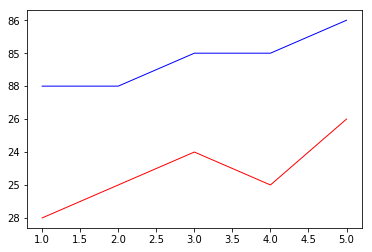

In [4]:
def sub_cb(client, userdata, msg):
    print("\nTopic:" + str(msg.topic) + " Message:" + str(msg.payload))
    # msg.payload是bytes类型，要转换
    s=msg.payload.decode()
    ss=s.split(',')
    draw(ss[0],ss[1])

siot.subscribe(IOT_pubTopic, sub_cb)
siot.loop()

接下来，我们就能够看到动态刷新的数据了。

**注：重新运行程序的时候，需先选择上方“服务”->再选择“重启 & 清空输出”。**

### 2.3 不同类别数据呈现

不同类别的数据，不能放在一个坐标轴中，比如温度的30和湿度的30，不是一个单位的量。这里采用了多条坐标轴的形式来解决，让一个图表有两条Y轴，分别作为两个数据的刻度。

**注意：请先选择上方“服务”->再选择“重启 & 清空输出”，否则将会收到多次的数据。**

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
x,p1,p2=[],[],[]
i=0
w=20 #设置数据的长度
def draw(v1,v2):
    global x,i,p1,p2
    i=i+1
    x.append(i)
    p1.append(v1)
    p2.append(v2)
    # 保持数据长度，避免图表越来越小
    if len(x)>w:
        x.pop(0)
        p1.pop(0)
        p2.pop(0)
    fig,ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.set_xlabel('X data')
    ax1.set_ylabel('data Y1',color="red")
    ax2.set_ylabel('data Y2',color="blue")
    #如果知道数值的区间，可以先设置好刻度
    ax1.set_yticks(range(0,50,10))
    ax2.set_yticks(range(0,100,20))
    ax1.plot(x,p1,'g-')
    ax2.plot(x,p2,'b-')
    display.clear_output(wait=True)
    plt.show()

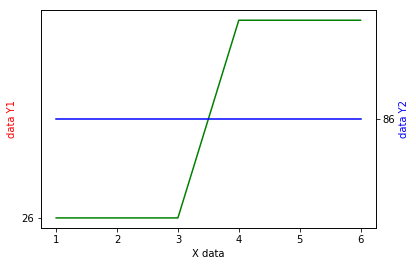

In [6]:
def sub_cb(client, userdata, msg):
    print("\nTopic:" + str(msg.topic) + " Message:" + str(msg.payload))
    # msg.payload是bytes类型，要转换
    s=msg.payload.decode()
    ss=s.split(',')
    draw(ss[0],ss[1])

siot.subscribe(IOT_pubTopic, sub_cb)
siot.loop()